In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from IPython.display import clear_output
import time

images = np.load('images.npy')
labels = np.load('labels.npy')
num_images,height,width = np.shape(images)
images = images.astype(float)
images = np.reshape(images,(num_images,height*width))/255.0


labels = labels.astype(int)



x_valid = images[45000:50000][:]
#print(np.shape(x_valid))
y_valid = labels[45000:50000]
#print(np.shape(y_valid))

x_train = images[0:45000][:]
#print(np.shape(x_train))
y_train = labels[0:45000]
#print(np.shape(y_train))


train_seqs = x_train
train_labels = y_train

val_seqs = x_valid
val_labels = y_valid


#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 5000
batch_size = 1;




In [146]:
#2 layer neural network model
class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(HEIGHT*WIDTH, 100)
        self.linear2 = torch.nn.Linear(100, 5)
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

model = TwoLayerNN()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

def accuracy(y,y_hat):
    correct = np.count_nonzero(y_hat.data.numpy()==y.data.numpy())
    return correct/y.data.shape[0]

In [147]:
for m in model.children():
    m.reset_parameters()

NUM_OPT_STEPS = 5000
batch_size = 1;


t = time.time()

train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 19.30 20.58
   100 33.50 31.56
   200 59.90 60.36
   300 60.60 60.22
   400 65.60 63.72
   500 63.10 65.72
   600 69.50 71.40
   700 68.90 69.02
   800 70.40 70.08
   900 68.80 68.80
  1000 74.20 72.92
  1100 68.40 71.02
  1200 71.90 70.50
  1300 71.40 73.32
  1400 68.10 69.76
  1500 69.90 71.18
  1600 68.20 70.24
  1700 71.30 72.28
  1800 73.00 73.18
  1900 70.90 70.38
  2000 72.70 75.12
  2100 71.50 71.32
  2200 73.50 73.48
  2300 71.30 74.56
  2400 71.00 73.30
  2500 72.40 72.50
  2600 72.80 72.46
  2700 72.10 72.16
  2800 74.20 73.64
  2900 71.00 72.94
  3000 68.60 68.56
  3100 73.40 72.52
  3200 73.20 75.56
  3300 72.40 75.44
  3400 74.20 73.68
  3500 74.40 74.06
  3600 74.90 76.14
  3700 75.20 74.84
  3800 73.60 74.50
  3900 75.60 76.14
  4000 71.60 75.32
  4100 73.50 75.54
  4200 76.30 75.20
  4300 73.30 75.10
  4400 75.30 75.72
  4500 72.10 73.68
  4600 69.70 73.58
  4700 78.80 76.16
  4800 74.70 75.42
  4900 69.70 71.82
Total training time approx. = 23.62570309638977 se

average accuracy =  0.69598


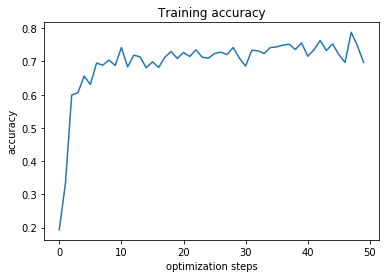

In [148]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.70334


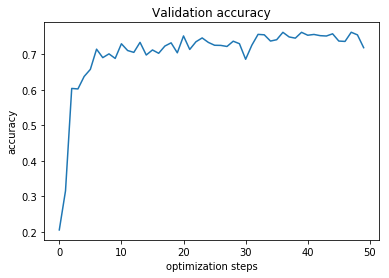

In [149]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [151]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.788 for 5000 optimization steps
Max validation accuracy= 0.7616 for 5000 optimization steps
batch_size= 1
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 23.62570309638977 secs


In [152]:
for m in model.children():
    m.reset_parameters()

In [153]:
#retraining the network with different parameters
#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 5000
batch_size = 10;

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [154]:
t = time.time()

train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 20.20 20.38
   100 67.20 66.56
   200 72.90 73.60
   300 74.20 73.98
   400 75.00 76.22
   500 77.10 77.94
   600 72.50 73.48
   700 76.10 77.28
   800 77.30 78.34
   900 76.60 76.48
  1000 78.30 79.12
  1100 77.50 78.70
  1200 78.50 77.90
  1300 80.50 79.80
  1400 79.90 80.14
  1500 80.80 80.34
  1600 79.90 81.18
  1700 81.60 81.02
  1800 79.20 79.22
  1900 80.70 80.84
  2000 79.60 81.36
  2100 80.00 80.50
  2200 81.30 81.38
  2300 81.30 81.44
  2400 80.60 81.16
  2500 82.10 81.08
  2600 80.90 81.66
  2700 82.30 81.90
  2800 81.10 82.20
  2900 85.60 82.84
  3000 82.30 82.74
  3100 79.10 81.62
  3200 81.40 82.26
  3300 82.60 82.58
  3400 83.40 82.78
  3500 82.50 82.56
  3600 84.90 83.48
  3700 83.80 83.02
  3800 83.30 83.44
  3900 84.80 83.66
  4000 83.30 83.24
  4100 83.00 82.82
  4200 83.40 82.86
  4300 82.20 83.88
  4400 84.00 83.54
  4500 84.40 82.84
  4600 84.60 83.50
  4700 86.10 84.22
  4800 84.60 84.14
  4900 83.70 82.46
Total training time approx. = 21.584566831588745 s

average accuracy =  0.79364


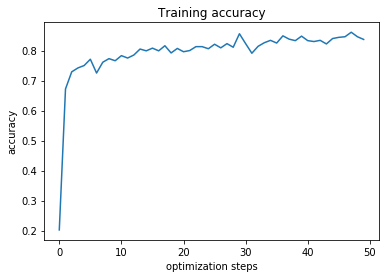

In [155]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.793936


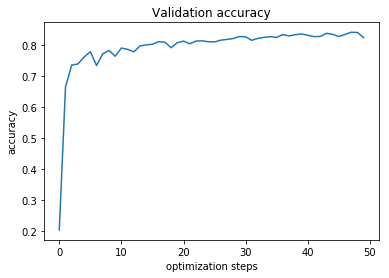

In [156]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [157]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.861 for 5000 optimization steps
Max validation accuracy= 0.8422 for 5000 optimization steps
batch_size= 10
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 21.584566831588745 secs


In [158]:
#retraining to maximize accuracy

for m in model.children():
    m.reset_parameters()

#retraining the network with different parameters
#constants
HEIGHT = np.shape(train_seqs)[1]
WIDTH = 1
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 5000
batch_size = 256

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))
        
elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 45.50 46.74
   100 78.20 77.96
   200 77.80 79.78
   300 83.20 80.76
   400 83.40 82.02
   500 83.50 83.08
   600 85.00 83.26
   700 84.60 83.88
   800 84.70 84.54
   900 85.60 84.78
  1000 84.60 85.12
  1100 87.00 84.74
  1200 87.40 85.56
  1300 89.50 86.02
  1400 87.40 86.18
  1500 88.90 86.16
  1600 89.40 86.80
  1700 90.40 86.14
  1800 88.80 86.48
  1900 89.00 86.22
  2000 89.70 86.64
  2100 90.40 86.58
  2200 87.60 86.12
  2300 91.50 86.48
  2400 91.10 86.92
  2500 90.20 86.70
  2600 93.00 86.14
  2700 90.80 86.14
  2800 93.00 86.64
  2900 92.30 86.78
  3000 93.10 86.56
  3100 92.40 86.70
  3200 93.60 86.52
  3300 93.30 86.28
  3400 94.00 87.00
  3500 93.40 86.58
  3600 94.40 86.46
  3700 94.80 86.32
  3800 93.80 86.46
  3900 92.70 86.86
  4000 94.00 86.50
  4100 95.00 86.42
  4200 93.40 86.72
  4300 93.80 86.16
  4400 94.00 85.94
  4500 95.50 85.92
  4600 94.40 86.54
  4700 95.20 86.54
  4800 94.80 86.66
  4900 95.90 86.38
Total training time approx. = 35.722007036209106 s

average accuracy =  0.893


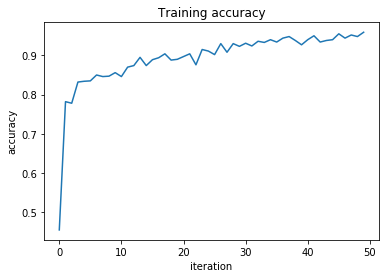

In [159]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.848176


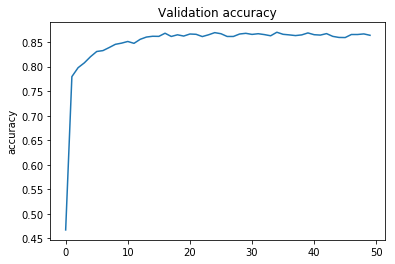

In [160]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
print('average accuracy = ',np.mean(val_accs))

In [161]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.959 for 5000 optimization steps
Max validation accuracy= 0.87 for 5000 optimization steps
batch_size= 256
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 35.722007036209106 secs
